# Satellite Image Classification

The goal of this mini-project is to have a playground for computer vision experiments. The task at hand is image classification from satellite images of 4 different classes: cloudy, desert, green area or water. The images are of size 64x64 or 256x256.

### Imports

In [12]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Data Loading and Normalization

In [2]:
means = torch.tensor([0.4028, 0.4334, 0.4291])  # Computed on the train set
stds = torch.tensor([0.2651, 0.1989, 0.1463])  # Computed on the train set

# Note that some images are of size 256^2 and some are of size 64^2. Resizing to 64^2 fixes this mismatch.
transform = transforms.Compose([transforms.Resize(64),
                                transforms.ToTensor(),
                                transforms.Normalize(means, stds)])

# Because this is just an educational mini-project, I won't use a proper test set (just train and validation)
# Also, to make experiments faster, I will use traditional train / validation splitting instead of cross validation
val_size = 1000
data_path = 'data/'
data = datasets.ImageFolder(data_path, transform=transform)
np.random.seed(0)  # Fix the seed to have the same validation set each time
val_idx = np.sort(np.random.choice(len(data), size=val_size, replace=False))
train_idx = np.array(list(set(np.arange(len(data))) - set(val_idx)))

train_bs = 16
val_bs = 32

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_dl = DataLoader(data, train_bs, sampler=train_sampler)
val_dl = DataLoader(data, val_bs, sampler=val_sampler)

In [3]:
# Verify that the mean and std on the train set is close to (0, 0, 0) and (1, 1, 1)
# Can also be used to compute means and stds the very first time on non-normalized dataset
sum_ = torch.tensor([0., 0., 0.])
sum_squares = torch.tensor([0., 0., 0.])
n_samples = 0
for batch_x, batch_y in val_dl:
    sum_ += batch_x.mean(axis=(2, 3)).sum(axis=0)
    sum_squares += (batch_x ** 2).mean(axis=(2, 3)).sum(axis=0)
    n_samples += len(batch_x)
mean = sum_ / len(train_idx)
std = (sum_squares / len(train_idx) - mean ** 2) ** (1./2.)
print(mean, std)

tensor([-0.0119, -0.0122, -0.0128]) tensor([0.4647, 0.4611, 0.4533])


### Exploration

In [4]:
label_to_str = {0: 'cloudy',
                1: 'desert',
                2: 'green_area',
                3: 'water'}

In [5]:
def denormalize(batch_x):
    return (batch_x * stds.reshape(1, -1, 1, 1)) + means.reshape(1, -1, 1, 1)

In [6]:
def show_batch(dl):
    images, labels = next(iter(dl))
    fig, ax = plt.subplots(figsize=(12, 4), dpi=240)
    ax.set_xticks(list(np.arange(dl.batch_size) * 66 + 33))
    ax.set_xticklabels([label_to_str[label.item()].replace('_', '\n') for label in labels], size=8)
    ax.set_yticks([])
    ax.imshow(make_grid(denormalize(images), nrow=dl.batch_size).permute(1, 2, 0).clamp(0,1))

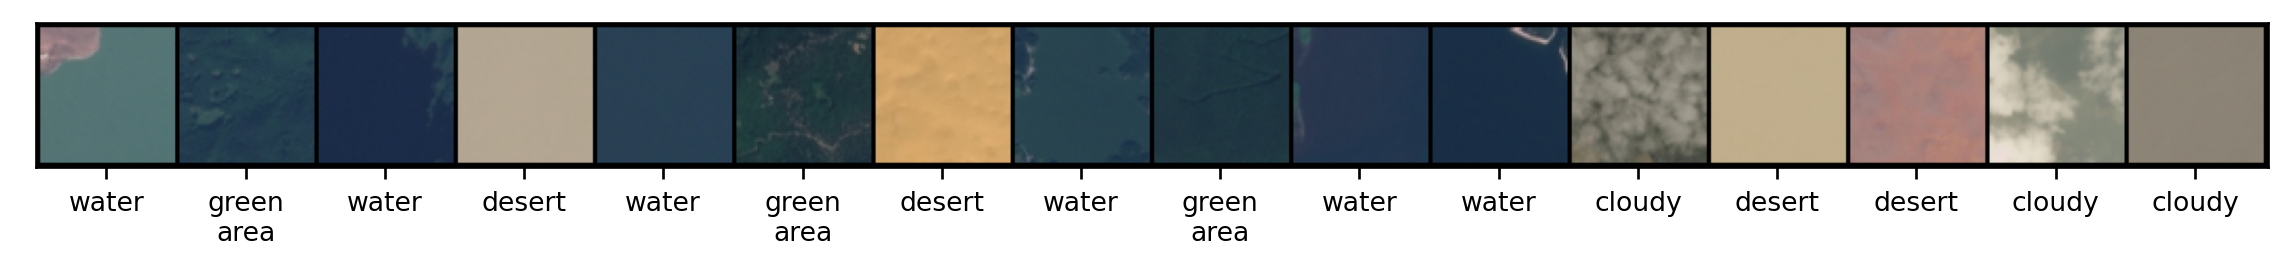

In [7]:
show_batch(train_dl)

As we can see, the colors seem to be the most important determining factor for this task of image classification. Some details of the image might still be necessary to distinguish between the hardest images, so it's probably still worth to use the usual computer vision architecture: deep convnets.

### Modelling

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=nn.MaxPool2d, activation_fn=nn.ReLU):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3)
        self.pooling = pooling(kernel_size=2, stride=2)
        self.activation_fn = activation_fn()
        self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        return self.bn(self.activation_fn(self.pooling(self.conv(x))))

class SatNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convnet = nn.ModuleList([
            ConvBlock(in_channels=3, out_channels=6, pooling=nn.MaxPool2d, activation_fn=nn.ReLU),
            ConvBlock(in_channels=6, out_channels=12, pooling=nn.MaxPool2d, activation_fn=nn.ReLU),
            ConvBlock(in_channels=12, out_channels=24, pooling=nn.MaxPool2d, activation_fn=nn.ReLU)
        ])
        
        self.mlp = nn.Sequential(
            nn.Dropout(p=.2),
            nn.Linear(864, 100),
            nn.ReLU(),
            nn.Dropout(p=.2),
            nn.Linear(100, 4))
        
    def forward(self, x):
        for conv_layer in self.convnet:
            x = conv_layer(x)
            
        x = x.flatten(start_dim=1, end_dim=3)
        return self.mlp(x)

In [9]:
def train(model, train_dl, criterion, optimizer):
    model.train()
    n_errors = 0
    n_samples = 0
    
    for batch_x, batch_y in train_dl:
        output = model(batch_x)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            pred = output.argmax(axis=1)
            errors = (batch_y != pred).sum().item()
            n_errors += errors
            n_samples += len(batch_y)
        
    accuracy = 1 - (n_errors / n_samples)  
    print('Train acc = {:.4f}'.format(accuracy))

In [10]:
def validate(model, val_dl):
    model.eval()
    n_errors = 0
    n_samples = 0
    
    with torch.no_grad():
        for batch_x, batch_y in val_dl:
            output = model(batch_x)
            pred = output.argmax(axis=1)
            errors = (batch_y != pred).sum().item()
            n_errors += errors
            n_samples += len(batch_y)
    accuracy = 1 - (n_errors / n_samples)  
    print('Val acc = {:.4f}'.format(accuracy))

In [13]:
criterion = nn.CrossEntropyLoss()
n_epochs = 20
model = SatNet()
optimizer = Adam(model.parameters())
scheduler = StepLR(optimizer, gamma=0.5, step_size=2)

for epoch in range(n_epochs):
    print('Epoch {}/{} - LR = {:.5f}'.format(epoch+1, n_epochs, optimizer.param_groups[0]['lr']))
    train(model, train_dl, criterion, optimizer)
    validate(model, val_dl)
    scheduler.step()
    print()

Epoch 1/20 - LR = 0.00100
Train acc = 0.8290
Val acc = 0.8990

Epoch 2/20 - LR = 0.00100
Train acc = 0.8879
Val acc = 0.9370

Epoch 3/20 - LR = 0.00050
Train acc = 0.9268
Val acc = 0.9450

Epoch 4/20 - LR = 0.00050
Train acc = 0.9296
Val acc = 0.9670

Epoch 5/20 - LR = 0.00025
Train acc = 0.9454
Val acc = 0.9690

Epoch 6/20 - LR = 0.00025
Train acc = 0.9564
Val acc = 0.9740

Epoch 7/20 - LR = 0.00013
Train acc = 0.9568
Val acc = 0.9740

Epoch 8/20 - LR = 0.00013
Train acc = 0.9534
Val acc = 0.9790

Epoch 9/20 - LR = 0.00006
Train acc = 0.9607
Val acc = 0.9750

Epoch 10/20 - LR = 0.00006
Train acc = 0.9596
Val acc = 0.9770

Epoch 11/20 - LR = 0.00003
Train acc = 0.9616
Val acc = 0.9800

Epoch 12/20 - LR = 0.00003
Train acc = 0.9652
Val acc = 0.9790

Epoch 13/20 - LR = 0.00002
Train acc = 0.9622
Val acc = 0.9720

Epoch 14/20 - LR = 0.00002
Train acc = 0.9626
Val acc = 0.9800

Epoch 15/20 - LR = 0.00001
Train acc = 0.9631
Val acc = 0.9800

Epoch 16/20 - LR = 0.00001
Train acc = 0.9670
Val